## 2.1 -  Implement K-means clustering from scratch

In [5]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img = np.float32(img)


def compute_mean(cluster, height, k):
    """
    Computes the mean (centers) of k clusters 
    -----
    args cluster: the array of cluster values
    args height: size of original data
    args k: number of clusters
    """
    sums = np.zeros((2,2))
    centers = np.zeros((k,2))
    count_0 = 0
    count_1 = 0
    for i in range(height):
        if(cluster[i] == 0):
            sums[0][0] += data[i][0] 
            sums[0][1] += data[i][1]
            count_0 += 1
        else:
            sums[1][0] += data[i][0] 
            sums[1][1] += data[i][1]
            count_1 += 1

    centers[0][0] = sums[0][0] / count_0
    centers[0][1] = sums[0][1] / count_0
    centers[1][0] = sums[1][0] / count_1
    centers[1][1] = sums[1][1] / count_1
    
    return centers

def k_means(img, k, iter_n):
    """
    Segments the image
    -----
    args img: image to be segmented
    args k: number of clusters
    args iter: iteration numbers
    """
    height, width, ch = img.shape
    
    # 1. Randomly select K centers
    # We do this by create a random array of RGB or GRAY values for each K 
    centers = np.random.random_sample((k, ch))*255
    
    cluster_iter = []
    for i in range(iter_n):
        # 2. Assign each point to the nearest cluster
        # Arr shape = (K, height, width), where K is cluster group
        clusters = calc_distance(img, centers)
        cluster_iter.append(clusters)
        
        # 3. Compute new mean for each cluster 
        new_centers = np.empty(shape=(k, ch))
        for j in range(k):
            np.mean(img[clusters[0]==j], axis=0, out=new_centers[j])
            
        # If new centers and centers are the same, exit iteration
        if((centers == new_centers).all()):
            break
        else:
            centers = new_centers
            
    return cluster_iter
    
def calc_distance(points, centers):
    """
    Calculates the eucilidean distance between points and center
    -----
    args points: the points 
    args centers: the centers of the distributions
    """
    dists = []
    # Calculate the distance between each point and each center
    for center in centers:
        dists.append([points - center])
    dists = np.linalg.norm(dists, axis=-1)
    
    # Return closest center of each point
    return np.argmin(dists, axis=0)
   
def show_plot(imgs, cols=3, isGray = False):  
    for i in range(len(imgs)):
        plt.figure(figsize=(20, 4))
        if(i==5):
            plt.title("Final Iteration")
        else:
            plt.title("Iteration number: "+str(i))
        plt.axis('off')
        if(isGray):
            plt.imshow(imgs[i][0].astype(np.uint8), cmap='gray')
        else:
            plt.imshow(imgs[i][0].astype(np.uint8))
        plt.show()  
        
def show_figures(imgs, isGray = False, isEM = False):
    """
    Plots figures in groups of three
    -----
    args imgs: array of images to be shown
    args isGray: if cmap = gray or not, defaulted to false
    """
    length = len(imgs)
    arr = [131, 132, 133]
    
    j=0
    for i in range(len(imgs)):
        if(i%3==0):
            plt.figure(figsize=(10,10))
            j=0
        plt.subplot(arr[j])
        plt.xticks([]), plt.yticks([])
        
        if(not isEM and isGray):
            plt.imshow(imgs[i][0].astype(np.uint8), cmap='gray')
        elif(not isEM):
            plt.imshow(imgs[i][0].astype(np.uint8))
        elif(isGray):
            plt.imshow(imgs[i].astype(np.uint8),  cmap='gray')
        else:
            plt.imshow(imgs[i][0].astype(np.uint8))
        
        j+=1
        if(i!=len(imgs)-1):
            plt.title("Iteration number: "+str(i))
            
    plt.title("Final Iteration")    
    plt.show()

### 2.1.1 - Applying K-means with K=2

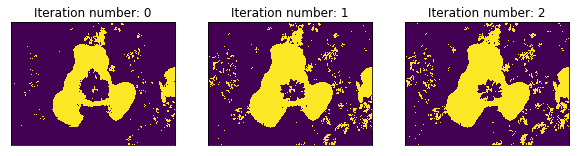

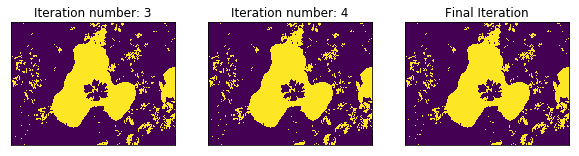

In [259]:
clusters = k_means(img, k=2, iter_n=6)
#show_plot(clusters)
show_figures(clusters)

### 2.1.2 - Applying K-means with K=3

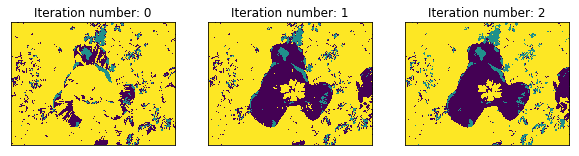

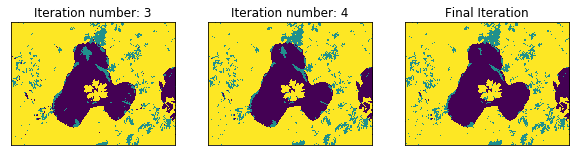

In [126]:
clusters = k_means(img, 3, 6)
show_figures(clusters)

### 2.1.3 - Applying K-means with grayscale and K=2

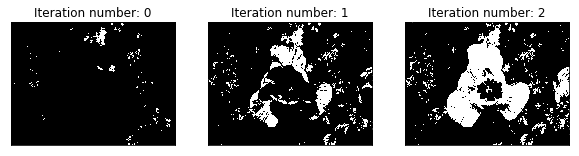

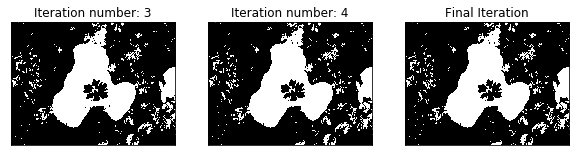

In [100]:
img_gray = cv2.imread("flower.jpg", cv2.COLOR_BGR2GRAY)
img_gray = np.float32(img)
clusters = k_means(img_gray, 2, 6)
show_figures(clusters, isGray = True)

### 2.1.4 - Applying K-means with grayscale and K=3

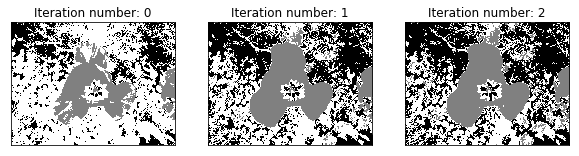

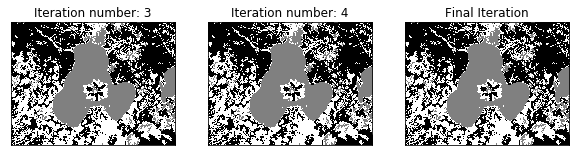

In [101]:
img_gray = cv2.imread("flower.jpg", cv2.COLOR_BGR2GRAY)
img_gray = np.float32(img)
clusters = k_means(img_gray, 3, 6)
show_figures(clusters, isGray = True)

### 2.1.5 - Comparing segmenetation for color and gray-scale

TODO : compare Color vs Gray scale


## 2.2 -  Implement EM-means clustering from scratch

In [102]:
import math

# prob(Pt | cluster i ) : Probability Density Function (PDF)
def prob_cluster(pixel, cent, std):
    """
    Calculate the probability of association between a point and a
    given Gaussian Distribution for each channel in a pixel.
    -----
    args pixel: the pixel. 
    args cent: the center of the Gaussian distribution. 
    args std: standard deviation OF Gaussian distribution. 
    -----
    returns: PDF of each gaussian K for one pixel. 
    """
    gauss_pdf = []
    for i in range(len(std)):
        point_pdf = []
        for j in range(len(pixel)):
            temp = 1/((math.sqrt(2*math.pi))*std[i][j]) * math.e**(-.5*math.pow((pixel[j]-cent[i][j])/std[i][j],2))
            point_pdf.append(temp)
        gauss_pdf.append(np.linalg.norm(point_pdf, axis=-1))  
    return gauss_pdf

def em(img, k, iterations=10):
    """
    Performs Expectation Maximization (EM) algorithm of an image 
    -----
    args img: the input image
    args k: the number of Gaussian Distributions
    args iterations: the number of iterations 
    -----
    """
    h, w, ch = img.shape
    
    if(k==1):
        raise Exception('K cannot be 1') 
    
    # Randomly define a center for each K Gaussian components
    # This center will be the randomly initialized peak for the initial gaussian
    gaus_peak = np.random.random((k, ch)) * 255.0
    
    # Probability that a point is in a given gaussian K
    prob = np.full(k, (1.0/k))
    # STD of a point being in a given gaussian K
    std_gaus = np.full((k, ch), (255.0/k))

    iter_pdf = []
    for iter in range(iterations):
        # E-Step
        # Assign each point a probability of being in each K Gaussian
        pdf = np.empty(shape=(h, w, k))
        for row in range(h):
            for col in range(w):
                pdf[row][col] = prob_cluster(img[row][col], gaus_peak, std_gaus)
    
        # Normalize the distribution
        pixel_sum = np.sum(pdf * prob, axis=-1)
        pixel_sum = pixel_sum.reshape((h, w, 1))
        pdf = pdf / pixel_sum
    
        # Assign each pixel to a gaussian distribution
        cluster_groups = np.argmax(pdf, axis=-1)
        iter_pdf.append(cluster_groups)
        
        # M-Step
        # Recalculate the Gaussian Distributions with newly assigned points
        for distr in range(k):
            distr_sum = 0
            for i in range(h):
                for j in range(w):
                    distr_sum += pdf[i, j, distr] * img[i, j]
            
            gaus_peak[distr] = distr_sum / np.sum(pdf[:,:,distr])
            curr_cluster = img[cluster_groups==distr]
            std_gaus[distr] = np.sqrt(np.var(curr_cluster, axis=0))
            pdf[distr] = np.size(curr_cluster) / np.size(img)
    
    return iter_pdf

### 2.2.1 - Applying EM with K=2

2


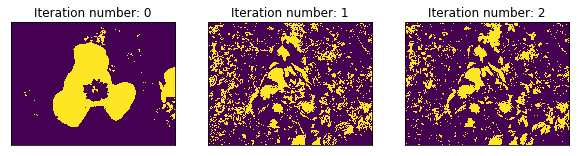

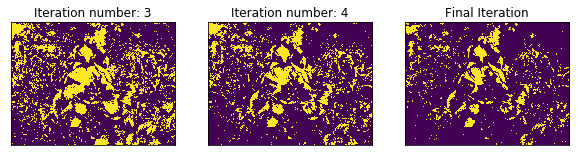

In [138]:
img = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img = np.float32(img)

em_gaussian2 = em(img, k=2, iterations=6)
show_figures(em_gaussian2, isEM = True)

### 2.2.2 - Applying EM with K=3

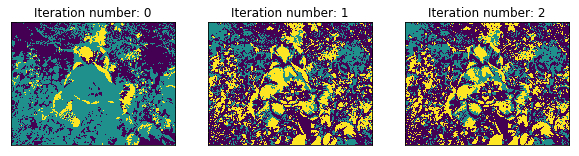

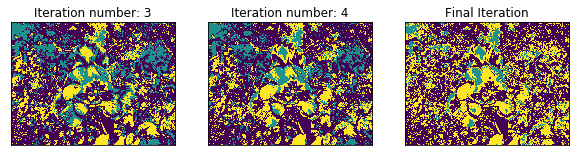

In [141]:
em_gaussian3 = em(img, k=3, iterations=6)
show_figures(em_gaussian3, isEM = True)

### 2.2.3 - Applying EM with Grayscale and K=2

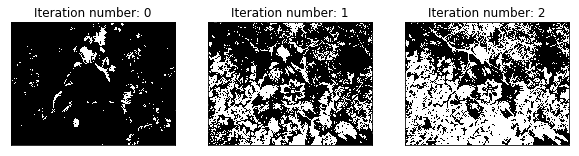

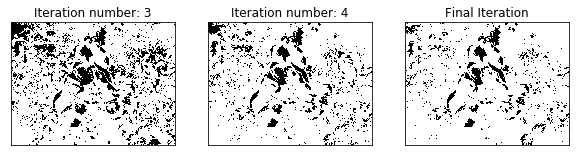

In [139]:
img_gray = cv2.imread("flower.jpg", cv2.COLOR_BGR2GRAY)
img_gray = np.float32(img_gray)

#em_gray_2 = em(img_gray, k=3, iterations=6)
show_figures(em_gray_2, isGray=True, isEM=True)

### 2.2.4 - Applying EM with Grayscale and K=3 

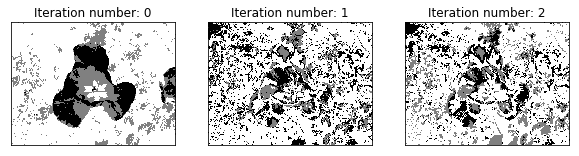

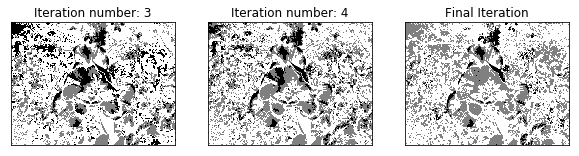

In [140]:
em_gray_3 = em(img_gray, k=3, iterations=6)
show_figures(em_gray_3, isGray=True, isEM=True)

### 2.4.5 - Comparing segmentation of color and gray-scale

// TODO

Comparing K-means and EM it can be seen that EM seperates the data much more signficantly as compared to K-means. This is because there is less overlapping between Gaussian distribution curves, thus the data can be better classified and seperated. Indeed, less overlapping leads to higher confidence and probability rate. 


# 2.3 - Cluster Random DataPoints with K-Means and GMM

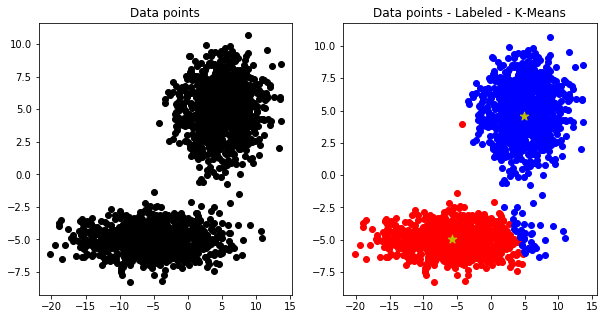

In [9]:
def k_means_data_points(data, k, iter_n):
    """
    Segments the image
    -----
    args img: image to be segmented
    args k: number of clusters
    args iter: iteration numbers
    """
    height, width = data.shape
    
    # 1. Randomly select K centers
    centers = np.random.random_sample((k, 2))*10

    cluster_iter = []
    for i in range(iter_n):
        # 2. Assign each point to the nearest cluster
        # Calculate distance between each point and each center
        distance = np.zeros((k, height))
        for i in range(0, height):
            for j in range(k):
                distance[j][i] = math.sqrt(
                    (centers[j][0] - data[i][0])**2 + (centers[j][1] - data[i][1])**2
                )

        # 2. Assign each point to the nearest cluster
        cluster = np.zeros(height)
        for i in range(len(distance[0])):
            if(distance[0][i] > distance[1][i]):
                cluster[i] = 0
            else:
                cluster[i] =1
        
        cluster_iter.append(cluster)

        # 3. and Compute new mean for each cluster 
        centers = compute_mean(cluster, height, k)

    return cluster_iter, centers

"""
Following code generates datapoints for question 1.1 part 3.
"""
data = np.float32(
    np.vstack((
        np.random.normal(
            loc = np.array([5,5]),
            scale = np.array([3,2]),
            size = (1000, 2)),
        np.random.normal(
            loc = np.array([-5, -5]),
            scale = np.array([5, 1]),
            size = (1000, 2)
        ))))

# Call K-Means with k=2 and iterations=5
k_means, centers = k_means_data_points(data, k=2, iter_n=5)
# Get the last iteration of K-meaqns
k_means = k_means[4]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data[:,0], data[:,1],"ko")
plt.title("Data points")

plt.subplot(122)

red_x = []
red_y = []
blue_x = []
blue_y = []

for i in range(2000):
    if(k_means[i] == 0):
        red_x.append(data[i,0])
        red_y.append(data[i,1])
    elif(k_means[i] == 1):
        blue_x.append(data[i,0])
        blue_y.append(data[i,1]) 
    
plt.scatter(red_x, red_y, color='r')
plt.scatter(blue_x, blue_y, color='b')
plt.scatter((centers[0][0], centers[1][0]), (centers[0][1], centers[1][1]), s=80, color='y', marker='*')
plt.title("Data points - Labeled - K-Means")
plt.show()

DATA:
[[  7.7397804   4.656243 ]
 [  1.7463394   7.3511457]
 [  7.665633    6.1216254]
 ...
 [ -9.297187   -4.012633 ]
 [-13.436622   -6.216584 ]
 [  0.8300465  -5.284741 ]]
********************
GAUS_PEAKS:
[[1.00588896 1.37917841]
 [1.72403101 2.52658132]]
********************
*************************
RETURN:
[1. 1. 1. ... 0. 0. 0.]


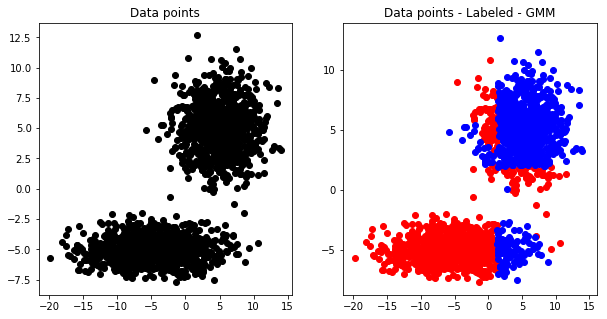

In [145]:
data = np.float32(
        np.vstack((
            np.random.normal(
                loc=np.array([5, 5]),
                scale=np.array([3, 2]),
                size = (1000, 2)),
            np.random.normal(
                loc=np.array([-5, -5]),
                scale=np.array([5, 1]),
                size = (1000, 2)
            ))))

print('DATA:')
print(data)
print('*'*20)

def prob_cluster(pixel, cent, std):
    """
    Calculate the probability of association between a point and a
    given Gaussian Distribution for each channel in a pixel.
    -----
    args pixel: the pixel. 
    args cent: the center of the Gaussian distribution. 
    args std: standard deviation OF Gaussian distribution. 
    -----
    returns: PDF of each gaussian K for one pixel. 
    """
    gauss_pdf = []
    # iterate over each gaussian distribution
    for i in range(len(std)):
        point_pdf = []
        # iterate over each point x,y
        for j in range(len(pixel)):
            temp = 1/((math.sqrt(2*math.pi))*std[i][j]) * math.e**(-.5*math.pow((pixel[j]-cent[i][j])/std[i][j],2))
            point_pdf.append(temp)
        gauss_pdf.append(np.linalg.norm(point_pdf, axis=0))  
    return gauss_pdf

def em(data, k, iterations=5):
    ch = 2
    h, w = data.shape

    # Randomly define a center for each K Gaussian components
    # This center will be the randomly initialized peak for the initial gaussian (x,y) for each K
    gaus_peak = np.random.random((k, ch)) * 5.0
    print('GAUS_PEAKS:')
    print(gaus_peak)
    print('*'*20)
    
    # Probability that a point is in a given gaussian K
    prob = np.full(k, (1.0 / k))
    # STD of each point (x,y) being in a given gaussian K
    std_gaus = np.full((k, ch), (1.0 / k))

    # E-Step
    # Assign each point a probability of being in each K Gaussian
    iter_pdf = []
    for iter in range(iterations):
        pdf = []
        for row in range(h):
            pdf.append(prob_cluster(data[row], gaus_peak, std_gaus))
        iter_pdf.append(pdf)

        # Assign each point to the nearest cluster
        cluster = np.zeros(h)
        for i in range(len(pdf)):
            if(pdf[i][0] > pdf[i][1]):
                cluster[i] = 0
            else:
                cluster[i] =1

        # M-Step
        # Recalculate the Gaussian Distributions with newly assigned points
        # PDF : 2,2000
        pdf_reshaped = np.reshape(pdf, (len(pdf),2))
        pdf_center_1 = pdf_reshaped[:,0]
        pdf_center_2 = pdf_reshaped[:,1]
        sums = np.zeros((2,2))
        counts = np.zeros(2)
        for i in range(h):
            #print('pdf ',pdf_center_1[distr])
            #print('data', data[i][distr])
            if(pdf_center_1[i] > pdf_center_2[i]):
                sums[0][0] += pdf_center_1[i]*data[i][0]
                sums[0][1] += pdf_center_1[i]*data[i][1]
                counts[0] += 1
            elif(pdf_center_1[i] < pdf_center_2[i]):
                sums[1][1] += pdf_center_2[i]*data[i][0]
                sums[0][1] += pdf_center_2[i]*data[i][1]
                counts[1] += 1

    gaus_peak[0][0] = sums[0][0] / counts[0]
    gaus_peak[0][1] = sums[0][1] / counts[0]
    gaus_peak[1][0] = sums[1][0] / counts[1]
    gaus_peak[1][1] = sums[1][1] / counts[1]

    return cluster
    

x = em(data, k=2, iterations=5)

print('*'*25)
print('RETURN:')
print(x)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data[:,0], data[:,1],"ko")
plt.title("Data points")

plt.subplot(122)

red_x = []
red_y = []
blue_x = []
blue_y = []

for i in range(2000):
    if(x[i] == 0):
        red_x.append(data[i,0])
        red_y.append(data[i,1])
    elif(x[i] == 1):
        blue_x.append(data[i,0])
        blue_y.append(data[i,1]) 
    
plt.scatter(red_x, red_y, color='r')
plt.scatter(blue_x, blue_y, color='b')
#plt.scatter((centers[0][0], centers[1][0]), (centers[0][1], centers[1][1]), s=80, color='y', marker='*')
plt.title("Data points - Labeled - GMM")
plt.show()

In [117]:
print(x[4][0])

5.364357831843263e-87


In [118]:
print(np.zeros(2))

[0. 0.]


In [101]:
tst = [[0.003859018637757312, 0.007080158441925853], [2.371157934322983e-30, 5.658601356837248e-07], [7.80567291960359e-34, 1.2902662695545348e-08], [1.32102987067913e-18, 3.7103063053269557e-06], [3.5006621951200025e-06, 2.6983894334371024e-05], [1.5752848733451023e-26, 3.2818512115567202e-65], [1.6515617505444403e-18, 4.4224012265663734e-52], [1.2002034317613595e-19, 1.945796505678208e-49]]
print(tst)

reshaped = np.reshape(tst, (len(tst),2))
print(reshaped)

pdf_center = reshaped[:,0]
print("-"*20)
print(pdf_center)

[[0.003859018637757312, 0.007080158441925853], [2.371157934322983e-30, 5.658601356837248e-07], [7.80567291960359e-34, 1.2902662695545348e-08], [1.32102987067913e-18, 3.7103063053269557e-06], [3.5006621951200025e-06, 2.6983894334371024e-05], [1.5752848733451023e-26, 3.2818512115567202e-65], [1.6515617505444403e-18, 4.4224012265663734e-52], [1.2002034317613595e-19, 1.945796505678208e-49]]
[[3.85901864e-03 7.08015844e-03]
 [2.37115793e-30 5.65860136e-07]
 [7.80567292e-34 1.29026627e-08]
 [1.32102987e-18 3.71030631e-06]
 [3.50066220e-06 2.69838943e-05]
 [1.57528487e-26 3.28185121e-65]
 [1.65156175e-18 4.42240123e-52]
 [1.20020343e-19 1.94579651e-49]]
--------------------
[3.85901864e-03 2.37115793e-30 7.80567292e-34 1.32102987e-18
 3.50066220e-06 1.57528487e-26 1.65156175e-18 1.20020343e-19]


In [ ]:
for distr in range(k):
        distr_sum = 0
        for i in range(h):
            if(distr==0):
                distr_sum_x += pdf[i][distr]*data[i][distr]
            elif(distr==1):
                 distr_sum_y += pdf[i][distr]*data[i][distr]
            